In [142]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from skfolio.datasets import load_sp500_dataset, load_sp500_implied_vol_dataset
from skfolio.preprocessing import prices_to_returns
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import coint



In [3]:
ticker = 'HD'
start_date = '2010-01-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
print(data.head(10))

[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open    Volume
Ticker             HD         HD         HD         HD         HD        HD
Date                                                                       
2010-01-04  19.933249  28.670000  29.150000  28.549999  29.150000  13120900
2010-01-05  20.079250  28.879999  28.990000  28.290001  28.730000  15594300
2010-01-06  20.009727  28.780001  29.000000  28.700001  28.879999   8833200
2010-01-07  20.246115  29.120001  29.219999  28.730000  28.860001  12058200
2010-01-08  20.148779  28.980000  29.240000  28.690001  29.000000  15609800
2010-01-11  19.578659  28.160000  29.020000  28.080000  29.000000  23670500
2010-01-12  19.453510  27.980000  28.350000  27.889999  28.150000  23075800
2010-01-13  19.557802  28.129999  28.250000  28.000000  28.000000  15639100
2010-01-14  19.675999  28.299999  28.440001  28.120001  28.120001  13208200
2010-01-15  19.863724  28.570000  28.690001  28.000000  28.309999  23013500


# Task 1 -- Step 3.1 Compute the classical historical mean and volatility estimators (as referenced in equations (9) and (14) in your notes).

In [134]:
ticker = 'HD'
start_date = '2010-01-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
print(data.head(10))

# calculate log-return
data['LogReturn'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
log_returns = data['LogReturn'].dropna()

# N is length of log-return 
N = len(log_returns)

# eq 9: drift (mean of log-return)
mu_hat = log_returns.mean()

# eq 14: variance of log-return
sigma2_hat = ((log_returns - mu_hat)**2).sum() / (N - 1)

# mean and volatility per day
print(f"N = {N} days")
print(f"μ_hat (mean of log-return) ≈ {mu_hat:.6f} per day")
print(f"σ²_hat (variance of log-return) ≈ {sigma2_hat:.6f} per day²")
print(f"σ_hat (volatility) ≈ {np.sqrt(sigma2_hat):.6f} per day")

# annualize the drift and volatility
trading_days = 252
mu_annual = mu_hat * trading_days
sigma2_annual = sigma2_hat * trading_days
sigma_annual = np.sqrt(sigma2_annual)

# annualized mean and volatility
print(f"μ_hat ≈ {mu_annual:.6f} per year (annualized drift)")
print(f"σ²_hat ≈ {sigma2_annual:.6f} per year (annualized variance)")
print(f"σ_hat ≈ {sigma_annual:.6f} per year (annualized volatility)")


[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open    Volume
Ticker             HD         HD         HD         HD         HD        HD
Date                                                                       
2010-01-04  19.933243  28.670000  29.150000  28.549999  29.150000  13120900
2010-01-05  20.079254  28.879999  28.990000  28.290001  28.730000  15594300
2010-01-06  20.009724  28.780001  29.000000  28.700001  28.879999   8833200
2010-01-07  20.246120  29.120001  29.219999  28.730000  28.860001  12058200
2010-01-08  20.148777  28.980000  29.240000  28.690001  29.000000  15609800
2010-01-11  19.578663  28.160000  29.020000  28.080000  29.000000  23670500
2010-01-12  19.453518  27.980000  28.350000  27.889999  28.150000  23075800
2010-01-13  19.557802  28.129999  28.250000  28.000000  28.000000  15639100
2010-01-14  19.675999  28.299999  28.440001  28.120001  28.120001  13208200
2010-01-15  19.863728  28.570000  28.690001  28.000000  28.309999  23013500
N = 3842 day

# Task 1 -- Step 3.2 Compute a rolling window estimator using a 30-day window. Plot the results for all estimators and explain your findings

[*********************100%***********************]  1 of 1 completed


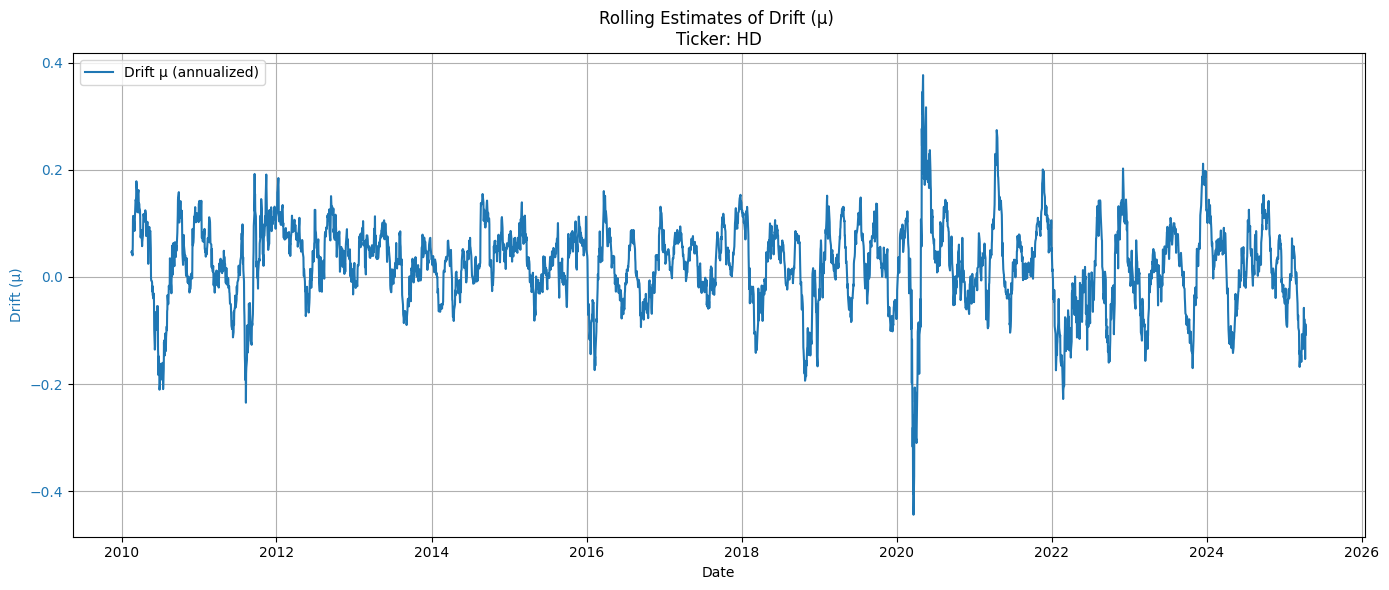

In [135]:
def sigma2_from_eq15(log_returns, N = 252, delta_t=1/252):
    if log_returns.isnull().any():
        return np.nan

    T = N * delta_t

    # μ̂_N
    mu_hat = log_returns.mean() / delta_t

    # Σ r_k^2
    sum_squared_returns = (log_returns ** 2).sum()

    # finally, we can calculate σ²̂_N
    sigma2_hat = (1 / ((N - 1) * delta_t)) * sum_squared_returns - (T / (N - 1)) * mu_hat**2
    return sigma2_hat

def sigma2_parkinson(high: pd.Series, low: pd.Series):
    """
    Parkinson estimator of variance.
    
    Parameters:
    - high: Series of daily high prices
    - low: Series of daily low prices
    - delta_t: time increment (default assumes daily data with 252 trading days/year)

    Returns:
    - Estimated annualized variance using Parkinson formula
    """
    # if (high.isnull().any()) or (low.isnull().any()):
    #     return np.nan

    log_hl = np.log(high / low)
    sigma2 = (1 / (4 * np.log(2))) * np.sum(log_hl ** 2)
    return sigma2

def compute_rolling_sigma2_parkinson(data: pd.DataFrame, window: int) -> pd.Series:
    """
    Computes rolling sigma² using Parkinson's estimator over the entire time series.

    Parameters:
    - data: pd.DataFrame with columns 'High' and 'Low'
    - window: rolling window size (int)

    Returns:
    - pd.Series of rolling sigma² values (same index as `data`)
    """
    result = [np.nan] * (window - 1)
    
    for i in range(window - 1, len(data)):
        window_high = data['High'].iloc[i - window + 1: i + 1]
        window_low = data['Low'].iloc[i - window + 1: i + 1]
        sigma2 = sigma2_parkinson(window_high, window_low)
        result.append(sigma2)
    
    return pd.Series(result, index=data.index)

def sigma2_garman_klass(high: pd.Series, low: pd.Series, open_: pd.Series, close: pd.Series):
    """
    Garman-Klass estimator of variance.

    Parameters:
    - high: Series of daily high prices
    - low: Series of daily low prices
    - open_: Series of daily open prices
    - close: Series of daily close prices
    - delta_t: time increment (default assumes daily data with 252 trading days/year)

    Returns:
    - Estimated annualized variance using Garman-Klass formula
    """
    # if any(s.isnull().any() for s in [high, low, open_, close]):
    #     return np.nan

    T = len(high)
    log_hl = np.log(high / low)
    log_oc = np.log(close / open_)

    term1 = (1 / (2 * T)) * np.sum(log_hl ** 2)
    term2 = ((2 * np.log(2) - 1) / T) * np.sum(log_oc ** 2)

    sigma2 = (term1 - term2)
    return sigma2

def compute_rolling_sigma2_garman_klass(data: pd.DataFrame, window: int) -> pd.Series:
    """
    Computes rolling sigma² using Garman-Klass estimator over the entire time series.

    Parameters:
    - data: pd.DataFrame with columns 'High', 'Low', 'Open', 'Close'
    - window: rolling window size (int)

    Returns:
    - pd.Series of rolling sigma² values (same index as `data`)
    """
    result = [np.nan] * (window - 1)
    
    for i in range(window - 1, len(data)):
        window_high = data['High'].iloc[i - window + 1: i + 1]
        window_low = data['Low'].iloc[i - window + 1: i + 1]
        window_open = data['Open'].iloc[i - window + 1: i + 1]
        window_close = data['Close'].iloc[i - window + 1: i + 1]
        sigma2 = sigma2_garman_klass(window_high, window_low, window_open, window_close)
        result.append(sigma2)
    
    return pd.Series(result, index=data.index)

# Downloading the data
ticker = 'HD'
start_date = '2010-01-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

N = 30 # Number of trading in 30 days
delta_t = 1 / N # Time increment in months

data['LogReturn'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
data['RollingMu'] = data['LogReturn'].rolling(window=N).mean() / delta_t  # see equation (10) in the appendix

# plotting the results
fig, ax1 = plt.subplots(figsize=(14, 6))
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Drift (μ)', color=color)
ax1.plot(data.index, data['RollingMu'], color=color, label='Drift μ (annualized)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
# formatting the plot
plt.title(f"Rolling Estimates of Drift (μ) \nTicker: {ticker}")
fig.tight_layout()
plt.grid(True)
plt.show()


d:\code-repo\作业\cf_assignment1\assignment1\zxx\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\code-repo\作业\cf_assignment1\assignment1\zxx\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\alex\AppData\Local\Temp\ipykernel_11892\2847011370.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data['Sigma2_parkinson'] = compute_rolling_sigma2_parkinson(data, window=N).astype(float)
d:\code-repo\作业\cf_assignment1\assignment1\zxx\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum w

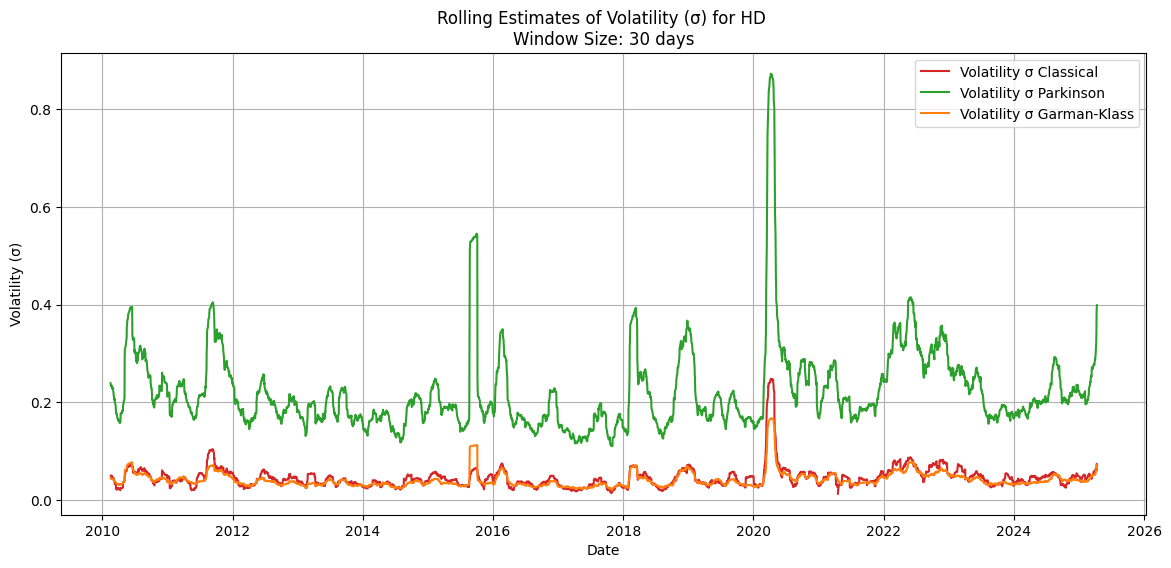

In [185]:
# classic volatility
data['Sigma2_rolling'] = data['LogReturn'].rolling(window=N).apply(sigma2_from_eq15, args=(N, delta_t), raw=False)
data['Sigma_rolling'] = np.sqrt(365/30 * data['Sigma2_rolling'])

# Parkinson volatility
data['Sigma2_parkinson'] = compute_rolling_sigma2_parkinson(data, window=N).astype(float)
data['Sigma_parkinson'] = np.sqrt(365/30 * data['Sigma2_parkinson'])

# Garman-Klass volatility
data['Sigma2_garman_klass'] = compute_rolling_sigma2_garman_klass(data, window=N).astype(float)
data['Sigma_garman_klass'] = np.sqrt(365/30 * data['Sigma2_garman_klass'])

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Sigma_rolling'], label='Volatility σ Classical', color='tab:red')
plt.plot(data.index, data['Sigma_parkinson'], label='Volatility σ Parkinson', color='tab:green')
plt.plot(data.index, data['Sigma_garman_klass'], label='Volatility σ Garman-Klass', color='tab:orange')
plt.title(f"Rolling Estimates of Volatility (σ) for {ticker} \nWindow Size: {N} days")
plt.xlabel('Date')
plt.ylabel('Volatility (σ)')
plt.legend()
plt.grid(True)
plt.show()


# Task 1 -- Step 3.3 Create a volatility signature plot by displaying the time-series average of the realized variance

[*********************100%***********************]  1 of 1 completed
d:\code-repo\作业\cf_assignment1\assignment1\zxx\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\alex\AppData\Local\Temp\ipykernel_11892\3724934622.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma2_rolling = compute_rolling_sigma2_parkinson(data, window=m).astype(float)
d:\code-repo\作业\cf_assignment1\assignment1\zxx\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axi

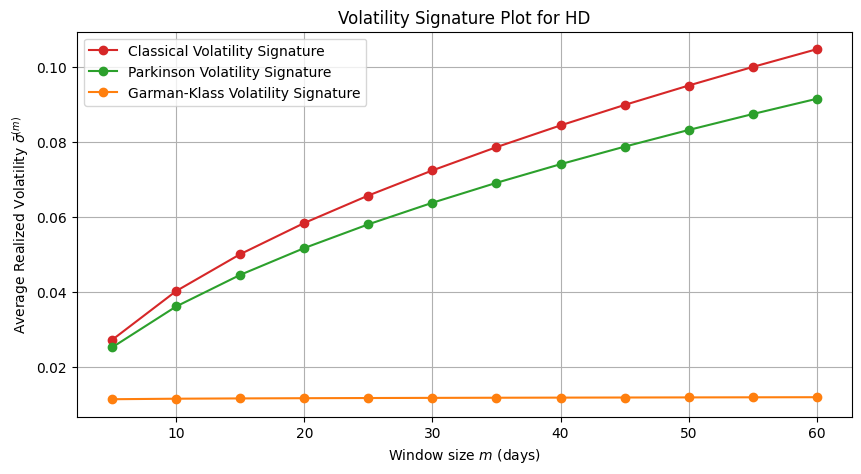

In [126]:
def compute_signature_plot(data: pd.DataFrame, m_list, price_col='Adj Close', sigma_type='classical'):
    """
    Computes the average realized volatility for different window sizes m (Volatility Signature Plot).
    
    Parameters:
    - data: DataFrame with a datetime index and 'Adj Close' column
    - m_list: list of window sizes to try, e.g., [5, 10, 20, 30, 60]
    - price_col: which column to use for log returns
    
    Returns:
    - result_df: DataFrame with columns ['m', 'avg_sigma']
    """
    avg_sigmas = []

    for m in m_list:
        delta_t = 1 / m
        log_returns = np.log(data[price_col] / data[price_col].shift(1))
        mu_rolling = log_returns.rolling(window=m).mean() / delta_t

        if sigma_type == 'parkinson':
            # Apply Parkinson estimator
            sigma2_rolling = compute_rolling_sigma2_parkinson(data, window=m).astype(float)
        elif sigma_type == 'garman_klass':  
            # Apply Garman-Klass estimator
            sigma2_rolling = compute_rolling_sigma2_garman_klass(data, window=m).astype(float)
        elif sigma_type == 'classical':
            # Apply classical estimator (eq 15)
            sigma2_rolling = log_returns.rolling(window=m).apply(
                sigma2_from_eq15, args=(m, delta_t), raw=False
            )
        else:
            raise ValueError("Invalid sigma_type. Choose from 'classical', 'parkinson', or 'garman_klass'.")
        
        sigma_rolling = np.sqrt(sigma2_rolling)
        avg_sigma = sigma_rolling.mean()
        avg_sigmas.append({'m': m, 'avg_sigma': avg_sigma})

    return pd.DataFrame(avg_sigmas)

ticker = 'HD'
start_date = '2010-01-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

m_values = list(range(5, 61, 5))  # e.g., 5 to 60 days

# classic volatility
signature_df_classic = compute_signature_plot(data, m_values, price_col='Adj Close', sigma_type='classical')

# parkinson volatility
signature_df_parkinson = compute_signature_plot(data, m_values, price_col='Adj Close', sigma_type='parkinson')

# garman-klass volatility
signature_df_garman_klass = compute_signature_plot(data, m_values, price_col='Adj Close', sigma_type='garman_klass')

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(signature_df_classic['m'], signature_df_classic['avg_sigma'], marker='o', color='tab:red', label='Classical Volatility Signature')
plt.plot(signature_df_parkinson['m'], signature_df_parkinson['avg_sigma'], marker='o', color='tab:green', label='Parkinson Volatility Signature')
plt.plot(signature_df_garman_klass['m'], signature_df_garman_klass['avg_sigma'], marker='o', color='tab:orange', label='Garman-Klass Volatility Signature')
plt.xlabel("Window size $m$ (days)")
plt.ylabel("Average Realized Volatility $\\bar{\\sigma}^{(m)}$")
plt.title(f"Volatility Signature Plot for {ticker}")
plt.legend()
plt.grid(True)
plt.show()


# Task 1 -- Step 3.4 Compare the realized variance estimators with the time series of implied volatilities for that ticker.

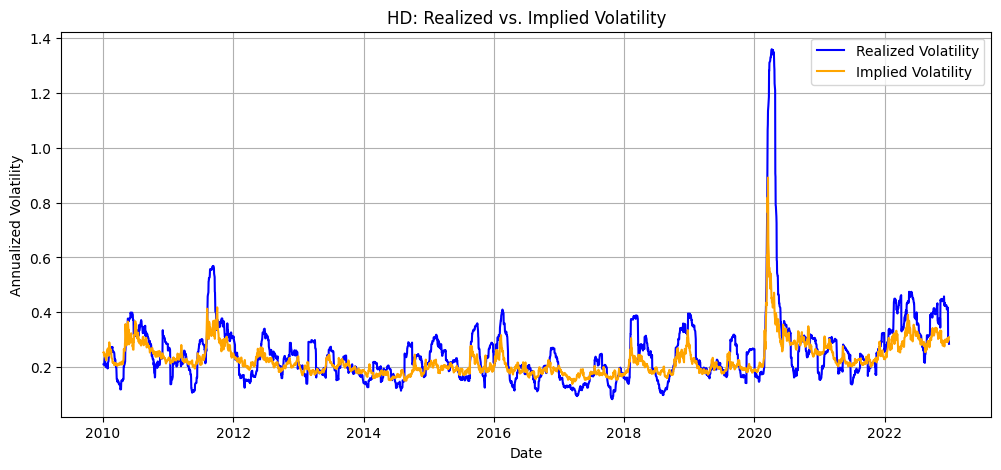

In [140]:
prices = load_sp500_dataset()
implied_vol = load_sp500_implied_vol_dataset()

ticker = "HD"
px = prices[ticker]
iv = implied_vol[ticker]
returns = np.log(px / px.shift(1))
rv = np.sqrt(365/30 * returns.rolling(window=30).apply(sigma2_from_eq15, args=(30, 1/30), raw=False))

vol_df = pd.concat([rv.rename("RealizedVol"), iv.rename("ImpliedVol")], axis=1).dropna()

plt.figure(figsize=(12, 5))
plt.plot(vol_df.index, vol_df["RealizedVol"], label="Realized Volatility", color="blue")
plt.plot(vol_df.index, vol_df["ImpliedVol"], label="Implied Volatility", color="orange")
plt.title(f"{ticker}: Realized vs. Implied Volatility")
plt.ylabel("Annualized Volatility")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


# Task 1 -- Step 4 (C). Compute the estimated VIX using the estimator VIX

In [182]:
# A function to manually calculate VIX using option chain data
def estimate_vix_strict(calls_df, puts_df, r_daily, tau_days=30, *, verbose=False):
    """
    用 CBOE 风格（τ=天，r=日利率）估算 VIX。

    参数:
    - calls_df: 看涨期权 DataFrame，含列 ['strike', 'bid', 'ask']
    - puts_df: 看跌期权 DataFrame，含列 ['strike', 'bid', 'ask']
    - r_daily: 无风险日利率 (如年利率5%则输入 0.05/365)
    - tau_days: 预期波动天数（默认30）
    - verbose: 是否打印中间变量（调试用）

    返回:
    - VIX: 估算的年化波动率（单位：百分数）
    """

    # 1. 计算 mid quote
    calls_df["mid"] = (calls_df["bid"] + calls_df["ask"]) / 2
    puts_df["mid"] = (puts_df["bid"] + puts_df["ask"]) / 2

    # 2. 合并期权表，找 forward price F（基于最小 call-put 差）
    merged = pd.merge(
        calls_df[["strike", "mid"]].rename(columns={"mid": "call_mid"}),
        puts_df[["strike", "mid"]].rename(columns={"mid": "put_mid"}),
        on="strike", how="inner"
    )
    merged["abs_diff"] = abs(merged["call_mid"] - merged["put_mid"])
    K0_row = merged.loc[merged["abs_diff"].idxmin()]
    K0 = K0_row["strike"]
    F = K0 + np.exp(r_daily * tau_days) * (K0_row["call_mid"] - K0_row["put_mid"])

    if verbose:
        print(f"Forward Price F = {F:.2f}, K0 = {K0:.2f}")

    # 3. 构造 OTM 期权价格 Q(K)
    puts_OTM = merged[merged["strike"] < F][["strike", "put_mid"]].rename(columns={"put_mid": "QK"})
    calls_OTM = merged[merged["strike"] > F][["strike", "call_mid"]].rename(columns={"call_mid": "QK"})
    center = pd.DataFrame([{
        "strike": K0,
        "QK": min(K0_row["call_mid"], K0_row["put_mid"])
    }])
    all_options = pd.concat([puts_OTM, center, calls_OTM]).sort_values("strike")

    # 4. 差分 ΔK
    K = all_options["strike"].values
    QK = all_options["QK"].values
    delta_K = np.zeros_like(K)
    delta_K[1:-1] = (K[2:] - K[:-2]) / 2
    delta_K[0] = K[1] - K[0]
    delta_K[-1] = K[-1] - K[-2]

    # 5. 估算方差
    integrand = (delta_K * QK) / (K ** 2)
    sigma2 = (2 * np.exp(r_daily * tau_days) / tau_days) * np.sum(integrand)

    # 6. 年化 VIX
    VIX = 100 * np.sqrt(sigma2)

    if verbose:
        print(f"Σ = {np.sum(integrand):.6f}, σ² = {sigma2:.6f}, VIX = {VIX:.2f}")

    return VIX

In [103]:
# 当前系统日期（确保是工作日）
today = dt.date.today()

# # VIX quoted data for specific date, from CBOE website
# 下载 SPX 的最近一年数据，找到“最近一个有效交易日”
spx_symbol = "^SPX"
spx_data = yf.download(spx_symbol, start=today - dt.timedelta(days=7), end=today + dt.timedelta(days=1))
lastBusDay = spx_data.index[-1].date()  # 转为 datetime.date 类型
# 下载对应日期的 VIX
vix_data = yf.download("^VIX", start=lastBusDay, end=lastBusDay + dt.timedelta(days=1))
print(vix_data.columns)

# 打印 VIX 数据
print(vix_data.head())
vix_data.to_csv("vix_data.csv", index=False)
# # 打印最后一个有效交易日
print(f"Last business day: {lastBusDay}")
vix_value = vix_data["Close"].values[0]
print(vix_value)


# # VIX data for the last business day, manually calculated from option chain data
# 获取 Option Chain（你的 Step 4b）
spx_ticker = yf.Ticker("^SPX")
# 动态获取所有期权日期，选离 30 天最近的那个
expiry_list = spx_ticker.options
target_date = min(expiry_list, key=lambda d: abs((dt.datetime.strptime(d, "%Y-%m-%d").date() - lastBusDay).days - 30))
print(f"Target expiry date: {target_date}")
# 下载期权链数据
chain = spx_ticker.option_chain(target_date)
calls_df = chain.calls
puts_df = chain.puts
# 记录并检查数据
calls_df.to_csv("spx_calls.csv", index=False)
puts_df.to_csv("spx_puts.csv", index=False)

# 年利率 → 日利率
r_annual = 0.04
r_daily = r_annual / 252

# 计算 VIX（τ = 30天）
vix = estimate_vix_strict(calls_df, puts_df, r_daily, tau_days=30, verbose=True)
print(f"📈 估算 VIX: {np.sqrt(252)*vix:.2f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MultiIndex([( 'Close', '^VIX'),
            (  'High', '^VIX'),
            (   'Low', '^VIX'),
            (  'Open', '^VIX'),
            ('Volume', '^VIX')],
           names=['Price', 'Ticker'])
Price           Close       High        Low       Open Volume
Ticker           ^VIX       ^VIX       ^VIX       ^VIX   ^VIX
Date                                                         
2025-04-11  37.560001  46.119999  36.849998  40.799999      0
Last business day: 2025-04-11
[37.56000137]
Target expiry date: 2025-05-12
Forward Price F = 5376.20, K0 = 5450.00
Σ = 0.004021, σ² = 0.000269, VIX = 1.64
📈 估算 VIX: 26.05


# # Task 1 -- Step 4 (D). Plot the historical estimated realized variances from Step 3 alongside the VIX time series

d:\code-repo\作业\cf_assignment1\assignment1\zxx\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Index(['RealizedVol', 'RealizedVol2', 'VIX'], dtype='object')


d:\code-repo\作业\cf_assignment1\assignment1\zxx\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


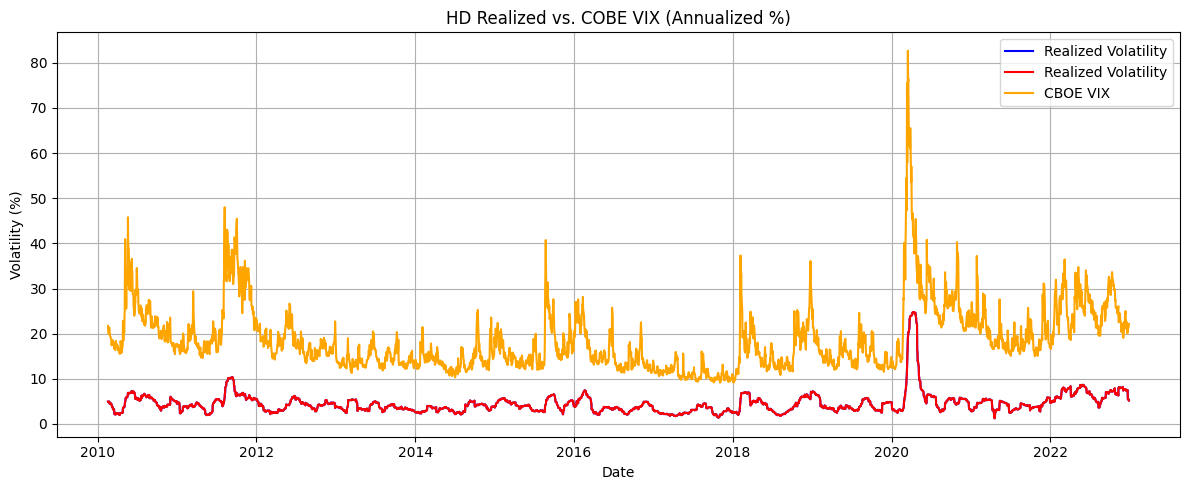

🔗 Pearson correlation = 0.7373, p-value = 0.0000
⚖️ Cointegration test: t-stat = -8.4966, p-value = 0.0000


In [181]:
# --- 1. 下载 SPX 和 VIX 历史数据 ---
start_date = "2010-01-01"
end_date = dt.date.today().strftime("%Y-%m-%d")

ticker = 'HD'
implied_vol = load_sp500_implied_vol_dataset()
prices = load_sp500_dataset()
px = prices[ticker]
iv = implied_vol[ticker]
returns = np.log(px / px.shift(1))
rv = np.sqrt(365/30 * returns.rolling(window=30).apply(sigma2_from_eq15, args=(30, 1/30), raw=False)) * 100
vol_df = pd.concat([rv.rename("RealizedVol"), iv.rename("ImpliedVol")], axis=1).dropna()


spx_data = yf.download(ticker, start=start_date, end=end_date)
vix_data = yf.download("^VIX", start=start_date, end=end_date)

# --- 2. 计算对数收益 ---
spx_close = spx_data["Close"]
spx_data['log-return'] = np.log(spx_close / spx_close.shift(1))

# --- 3. 滚动窗口估算年化 realized volatility ---
N = 30
delta_t = 1 / N  # 每年交易天数
rv2 = spx_data['log-return'].rolling(window=N).apply(sigma2_from_eq15, args=(N, delta_t), raw=False)
spx_data['RealizedVol2'] = np.sqrt(rv2 * 365/30) * 100

# --- 5. 整理并合并 VIX 收盘价（CBOE 官方年化波动率） ---
vix_data['VIX'] = vix_data["Close"]

vol_df = pd.concat([
    rv.rename("RealizedVol"),
    spx_data['RealizedVol2'],
    vix_data['VIX']
], axis=1).dropna()

# --- 6. 可视化比较 ---
print(vol_df.columns)

plt.figure(figsize=(12, 5))
plt.plot(vol_df.index, vol_df["RealizedVol"], label="Realized Volatility", color="blue")
plt.plot(vol_df.index, vol_df["RealizedVol2"], label="Realized Volatility", color="red")
plt.plot(vol_df.index, vol_df["VIX"], label="CBOE VIX", color="orange")
plt.title("HD Realized vs. COBE VIX (Annualized %)")
plt.ylabel("Volatility (%)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 7. 相关性分析 ---
corr, pval = pearsonr(vol_df["RealizedVol"], vol_df["VIX"])
print(f"🔗 Pearson correlation = {corr:.4f}, p-value = {pval:.4f}")

# --- 8. 协整检验 ---
coint_t, pval_coint, _ = coint(vol_df["RealizedVol"], vol_df["VIX"])
print(f"⚖️ Cointegration test: t-stat = {coint_t:.4f}, p-value = {pval_coint:.4f}")
